In [45]:
import gensim
from gensim.models import Word2Vec
import numpy as np
from gensim.models.word2vec import Text8Corpus
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re


In [12]:
text8_path="text8"
analogy_file = "questions-words.txt"

In [13]:
           
def cosine_distance(v1, v2):
    return (1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

# Função para avaliar o modelo com dados de analogia
def evaluate_model(model, analogy_file):
    total_distance = 0
    count = 0
    
    with open(analogy_file, 'r') as f:
        for line in f:
            if line.startswith(':'):  # Ignorar categorias de analogia
                continue
            words = line.strip().split()
            if all(word in model.wv for word in words):
                # Operação de vetores
                result_vector = model.wv[words[1]] - model.wv[words[0]] + model.wv[words[2]]
                expected_vector = model.wv[words[3]]
                
                # Distância do cosseno
                distance = cosine_distance(expected_vector, result_vector)
                total_distance += distance
                count += 1
    return total_distance / count if count > 0 else float('inf')


In [20]:
def train_model(model_params: dict, corpus: list) -> Word2Vec.__class__:
    model = Word2Vec(
        sentences=corpus,
        vector_size=model_params['vector_size'],
        window=model_params['window'],
        sg=model_params['sg'],  # CBOW (0) ou Skip-gram (1)
        alpha=model_params['alpha'],  # Taxa de aprendizado inicial
        negative=model_params['negative'],
        min_count=5
        sample=1e-3
        workers=4
    )
    
    return model

SyntaxError: invalid syntax. Perhaps you forgot a comma? (375468633.py, line 9)

In [21]:
# Função principal
def train_and_evaluate(analogy_file, parameters):
    corpus = Text8Corpus(text8_path)
    results = []
    min_distance = float('inf')
    best_model = Word2Vec()
    best_params = {}

    for param in parameters:
        print(f"Treinando modelo com parâmetros: {param}")
        model = train_model(param, corpus)
        
        # Avaliação do modelo
        distance = evaluate_model(model, analogy_file)
        results.append((param, distance))

        if ( distance < min_distance ):
            min_distance = distance
            best_model = model
            best_params = param

        print(f"Distância média: {distance}")

    
    print("\nMelhor modelo:", best_params)
    print("Menor distância média:", min_distance)

    return best_model, best_params

In [23]:
# Parâmetros para experimentação
parameters = [
    #CBOW 
    # {'vector_size': 10, 'window': 3, 'sg': 0, 'alpha': 0.001, 'negative': 5},
    # {'vector_size': 10, 'window': 5, 'sg': 0, 'alpha': 0.001, 'negative': 5},  
    # {'vector_size': 10, 'window': 10, 'sg': 0, 'alpha': 0.001, 'negative': 5}, 
    # {'vector_size': 30, 'window': 3, 'sg': 0, 'alpha': 0.001, 'negative': 5},
    # {'vector_size': 30, 'window': 5, 'sg': 0, 'alpha': 0.001, 'negative': 5},  
    # {'vector_size': 30, 'window': 10, 'sg': 0, 'alpha': 0.001, 'negative': 5}, 
    # {'vector_size': 60, 'window': 3, 'sg': 0, 'alpha': 0.001, 'negative': 5}, 
    # {'vector_size': 60, 'window': 5, 'sg': 0, 'alpha': 0.001, 'negative': 5},
    # {'vector_size': 60, 'window': 10, 'sg': 0, 'alpha': 0.001, 'negative': 5}, 

    # Skip-gram 
    {'vector_size': 10, 'window': 3, 'sg': 1, 'alpha': 0.001, 'negative': 5},  
    {'vector_size': 10, 'window': 5, 'sg': 1, 'alpha': 0.001, 'negative': 5}, 
    {'vector_size': 10, 'window': 10, 'sg': 1, 'alpha': 0.001, 'negative': 5},
    {'vector_size': 30, 'window': 3, 'sg': 1, 'alpha': 0.001, 'negative': 5},  
    {'vector_size': 30, 'window': 5, 'sg': 1, 'alpha': 0.001, 'negative': 5}, 
    {'vector_size': 30, 'window': 10, 'sg': 1, 'alpha': 0.001, 'negative': 5},
    # {'vector_size': 60, 'window': 3, 'sg': 1, 'alpha': 0.001, 'negative': 5},  
    # {'vector_size': 60, 'window': 5, 'sg': 1, 'alpha': 0.001, 'negative': 5}, 
    # {'vector_size': 60, 'window': 10, 'sg': 1, 'alpha': 0.001, 'negative': 5},


]

# Executar
best_model, best_params = train_and_evaluate(analogy_file, parameters)

Treinando modelo com parâmetros: {'vector_size': 10, 'window': 3, 'sg': 1, 'alpha': 0.001, 'negative': 5}
Distância média: 0.2607987963658268
Treinando modelo com parâmetros: {'vector_size': 10, 'window': 5, 'sg': 1, 'alpha': 0.001, 'negative': 5}
Distância média: 0.21277569499249022
Treinando modelo com parâmetros: {'vector_size': 10, 'window': 10, 'sg': 1, 'alpha': 0.001, 'negative': 5}
Distância média: 0.16931704455920596
Treinando modelo com parâmetros: {'vector_size': 30, 'window': 3, 'sg': 1, 'alpha': 0.001, 'negative': 5}
Distância média: 0.2611436001427811
Treinando modelo com parâmetros: {'vector_size': 30, 'window': 5, 'sg': 1, 'alpha': 0.001, 'negative': 5}
Distância média: 0.2229829878847902
Treinando modelo com parâmetros: {'vector_size': 30, 'window': 10, 'sg': 1, 'alpha': 0.001, 'negative': 5}
Distância média: 0.19322664062613215

Melhor modelo: {'vector_size': 10, 'window': 10, 'sg': 1, 'alpha': 0.001, 'negative': 5}
Menor distância média: 0.16931704455920596


How many words were learnt?

In [25]:
len(best_model.wv.key_to_index) 

71290

In [101]:
def test_analogies(model, test_cases):
    print("\nTestando analogias experimentais:")
    for analogy in test_cases:
        word_a, word_b, word_c = analogy[:3]
        if all(word in model.wv for word in [word_a, word_b, word_c]):
            result_vector = model.wv[word_b] - model.wv[word_a] + model.wv[word_c]
            closest_word = model.wv.most_similar([result_vector], topn=1)[0][0]
            print(f"{word_a} -> {word_b}, {word_c} -> {closest_word}")
            print( model.wv.most_similar([result_vector], topn=5))

In [104]:
test_cases = [
    ['boy', 'brother', 'girl'],
    ["man", "king", "woman"],  
    ["paris", "france", "berlin"],     
    ["man", "actor", "woman"],
    ["man", "husband", "woman"],
    ["day", "sun", "night"]
]
test_analogies(best_model, test_cases)


Testando analogias experimentais:
boy -> brother, girl -> daughter
[('daughter', 0.9687771797180176), ('son', 0.9686810970306396), ('wife', 0.9545168876647949), ('brother', 0.9519451260566711), ('heir', 0.9494006037712097)]
man -> king, woman -> emperor
[('emperor', 0.9855666756629944), ('pope', 0.9818410873413086), ('king', 0.9737104773521423), ('sons', 0.9725826978683472), ('constantine', 0.9711017608642578)]
paris -> france, berlin -> germany
[('germany', 0.988174319267273), ('russia', 0.9863964319229126), ('finland', 0.981310248374939), ('china', 0.9803701639175415), ('israeli', 0.9792732000350952)]
man -> actor, woman -> actor
[('actor', 0.9846175909042358), ('actress', 0.9837008714675903), ('singer', 0.9817619919776917), ('musician', 0.9616746306419373), ('born', 0.9578732848167419)]
man -> husband, woman -> husband
[('husband', 0.970988929271698), ('married', 0.951518177986145), ('daughters', 0.9503814578056335), ('younger', 0.9487897753715515), ('divorced', 0.9420365691184998)

In [33]:
print(cosine_distance(best_model.wv['man'], best_model.wv['woman'])) 

0.03071349859237671


In [35]:
print(best_model.wv.most_similar(positive=['woman', 'king'], negative=['man']))

[('emperor', 0.9833693504333496), ('pope', 0.9783900380134583), ('sons', 0.9730967879295349), ('constantine', 0.9686971306800842), ('elizabeth', 0.9626913070678711), ('married', 0.9606030583381653), ('julius', 0.9605692028999329), ('prince', 0.9597665071487427), ('throne', 0.9589797854423523), ('jacob', 0.9581308364868164)]


Which are the most feminine words?

In [ ]:
print(best_model.wv.most_similar(positive=['woman'], negative=['man'], topn=10))


[('narendra', 0.6472424268722534), ('matique', 0.6436644196510315), ('climacus', 0.6284105181694031), ('anzio', 0.6187710165977478), ('coiner', 0.6165974736213684), ('arakawa', 0.6110766530036926), ('dogpatch', 0.6049278974533081), ('nadesico', 0.5970968008041382), ('dimanche', 0.5965697765350342), ('radle', 0.5956652760505676)]


And the most masculine?

In [43]:
print(best_model.wv.most_similar(positive=['man'], negative=['woman'], topn=10))


[('law', 0.4614548981189728), ('magnes', 0.4605790376663208), ('intelligence', 0.45258358120918274), ('right', 0.4387674927711487), ('branch', 0.4324988126754761), ('theory', 0.42667433619499207), ('formulates', 0.41904985904693604), ('acd', 0.417023241519928), ('clamped', 0.4137336015701294), ('unconstitutionality', 0.409860223531723)]


## Visualizing in a 2D space

In [62]:
def tsne_plot(words, vectors, iterations=1000, seed=42, title="t-SNE Word Embeddings"):
    """
    Creates a t-SNE plot of word embeddings.
    
    Parameters:
    - words: List of words to plot.
    - vectors: Corresponding vectors for the words.
    - iterations: Number of t-SNE iterations.
    - seed: Random seed for reproducibility.
    - title: Title for the plot.
    """
    # Create t-SNE model and fit-transform the vectors
    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', 
                       n_iter=iterations, random_state=seed)
    new_values = tsne_model.fit_transform(vectors)

    # Extract x and y coordinates
    x, y = new_values[:, 0], new_values[:, 1]

    # Plot the results
    plt.figure(figsize=(10, 10))
    
    # Annotate points with words
    for i in range(len(words)):
        
        plt.scatter(x[i], y[i])
        plt.annotate(words[i], xy=(x[i], y[i]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')

    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title(title)
    plt.grid(True)
    plt.show()


In [63]:
# Initialize lists for words and their corresponding vectors
my_word_list = []
my_word_vectors = []

# List of words to explore
words_to_explore = [
    'woman', 'man', 'queen', 'king', 'human', 'person', 'girl', 'child', 'boy',
    'salad', 'lettuce', 'tomato', 'soup', 'turnip', 'arugula', 'pepper', 
    'greens', 'barley', 'bean', 'stew', 'carrot'
]

for word in words_to_explore:
    try:
        if word not in my_word_list:
            my_word_vectors.append(best_model.wv[word])
            my_word_list.append(word)
    except KeyError:  # Ignore words not in the vocabulary
        continue


/home/hick/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


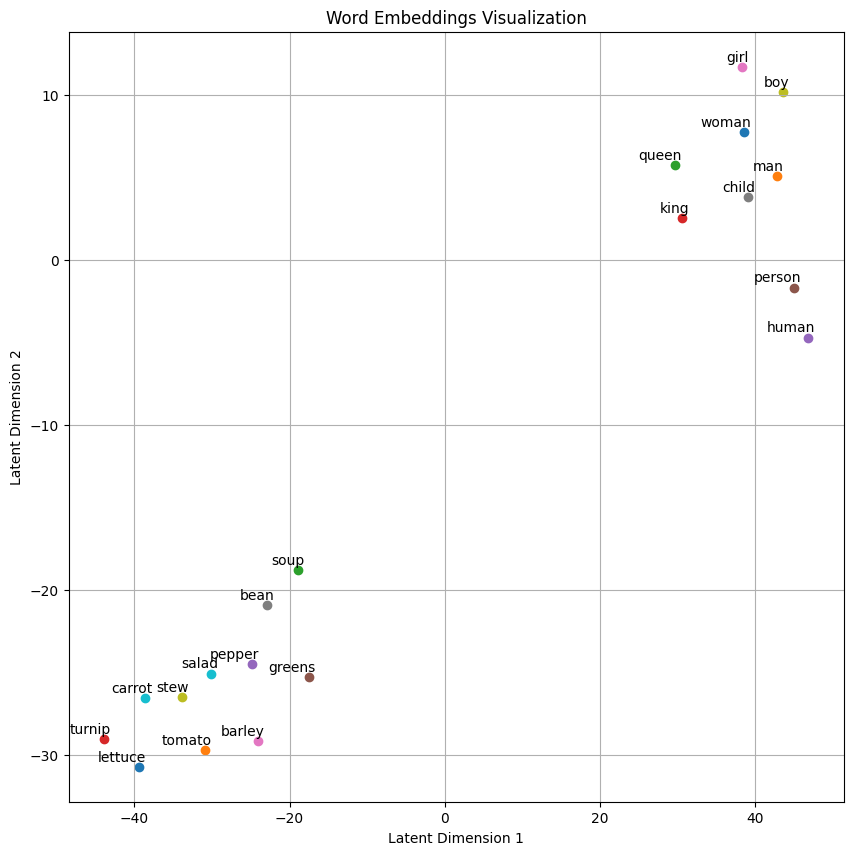

In [64]:
# Generate the t-SNE plot
tsne_plot(my_word_list, np.array(my_word_vectors), iterations=1000, seed=42, title="Word Embeddings Visualization")
